In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf

import os
import gc
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1024)
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

mpl.rcParams['font.family'] = "serif"
plt.style.use('ggplot')
sns.set(style='ticks', palette='Set2')

%matplotlib inline

In [2]:
ROOT = '/home/duoan/work/input/microsoft-malware-prediction/'
df_trn = pd.read_csv(ROOT + 'train.csv')
df_tst = pd.read_csv(ROOT + 'test.csv')
print('dataframe shape', df_trn.shape, df_tst.shape)

dataframe shape (8921483, 83) (7853253, 82)


In [3]:
IDs_trn = df_trn['MachineIdentifier']
IDs_tst = df_tst['MachineIdentifier']

y = df_trn['HasDetections']

df_trn.drop(['MachineIdentifier','HasDetections'], axis=1, inplace=True)
df_tst.drop('MachineIdentifier', axis=1, inplace=True)

_ = gc.collect()

In [4]:
df_trn.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.00000,0,nan,53447.00000,1.00000,1.00000,1,29,128035.00000,18.00000,35.00000,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.00000,0,NaN,0.00000,137.00000,NaN,1.00000,1.00000,Desktop,Windows.Desktop,2668.00000,9124.00000,4.00000,5.00000,2341.00000,NaN,476940.00000,HDD,299451.00000,0,4096.00000,Desktop,18.90000,1440.00000,900.00000,Desktop,NaN,4294967295.00000,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.00000,119,UNKNOWN,0,IS_GENUINE,Retail,nan,0.00000,Retail,nan,628.00000,36144.00000,0,nan,0.00000,0,0,0.00000,0.00000,10.00000
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.00000,0,nan,53447.00000,1.00000,1.00000,1,93,1482.00000,18.00000,119.00000,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.00000,0,NaN,0.00000,137.00000,NaN,1.00000,1.00000,Notebook,Windows.Desktop,2668.00000,91656.00000,4.00000,5.00000,2405.00000,NaN,476940.00000,HDD,102385.00000,0,4096.00000,Notebook,13.90000,1366.00000,768.00000,Mobile,NaN,1.00000,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.00000,31,UNKNOWN,0,OFFLINE,Retail,nan,0.00000,NOT_SET,nan,628.00000,57858.00000,0,nan,0.00000,0,0,0.00000,0.00000,8.00000
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.00000,0,nan,53447.00000,1.00000,1.00000,1,86,153579.00000,18.00000,64.00000,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.00000,0,NaN,0.00000,137.00000,RequireAdmin,1.00000,1.00000,Desktop,Windows.Desktop,4909.00000,317701.00000,4.00000,5.00000,1972.00000,NaN,114473.00000,SSD,113907.00000,0,4096.00000,Desktop,21.50000,1920.00000,1080.00000,Desktop,NaN,4294967295.00000,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.00000,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,nan,0.00000,Retail,nan,142.00000,52682.00000,0,nan,0.00000,0,0,0.00000,0.00000,3.00000
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.00000,0,nan,53447.00000,1.00000,1.00000,1,88,20710.00000,nan,117.00000,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.00000,0,NaN,0.00000,1

In [5]:
y.value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

In [ ]:
# Number of NaNs for each object
df_trn['NAN_CNT'] = df_trn.isnull().sum(axis=1)
df_tst['NAN_CNT'] = df_tst.isnull().sum(axis=1)

df_trn['NAN_CNT'].head(15)

0     8
1     8
2     7
3     8
4     4
5     4
6     9
7     3
8     4
9     5
10    8
11    8
12    8
13    8
14    7
Name: NAN_CNT, dtype: int64

In [10]:
# Number of NaNs for each column
nan_cols_trn = df_trn.isnull().sum(axis=0).sort_values(ascending=False)
nan_cols_tst = df_tst.isnull().sum(axis=0).sort_values(ascending=False)

display(nan_cols_trn.head(15))
print('-' * 90)
display(nan_cols_tst.head(15))

PuaMode                                  8919174
Census_ProcessorClass                    8884852
DefaultBrowsersIdentifier                8488045
Census_IsFlightingInternal               7408759
Census_InternalBatteryType               6338429
Census_ThresholdOptIn                    5667325
Census_IsWIMBootEnabled                  5659703
SmartScreen                              3177011
OrganizationIdentifier                   2751518
SMode                                     537759
CityIdentifier                            325409
Wdft_IsGamer                              303451
Wdft_RegionIdentifier                     303451
Census_InternalBatteryNumberOfCharges     268755
Census_FirmwareManufacturerIdentifier     183257
dtype: int64

------------------------------------------------------------------------------------------


PuaMode                                  7851065
Census_ProcessorClass                    7835022
DefaultBrowsersIdentifier                7546134
Census_IsFlightingInternal               6673962
Census_InternalBatteryType               5979844
SMode                                    5831272
Census_ThresholdOptIn                    5529515
Census_IsWIMBootEnabled                  5522707
SmartScreen                              3498402
OrganizationIdentifier                   2482129
Wdft_IsGamer                              302857
Wdft_RegionIdentifier                     302857
Census_InternalBatteryNumberOfCharges     239233
Census_FirmwareManufacturerIdentifier     198634
CityIdentifier                            191962
dtype: int64

## Dataset cleaning¶

### Removal the high missing ratio features

In [11]:
limit = 0.35
high_missing_cols_trn = nan_cols_trn[nan_cols_trn > df_trn.shape[0] * limit]
high_missing_cols_tst = nan_cols_tst[nan_cols_tst > df_tst.shape[0] * limit]

display(high_missing_cols_trn)
print('-' * 90)
display(high_missing_cols_tst)

PuaMode                       8919174
Census_ProcessorClass         8884852
DefaultBrowsersIdentifier     8488045
Census_IsFlightingInternal    7408759
Census_InternalBatteryType    6338429
Census_ThresholdOptIn         5667325
Census_IsWIMBootEnabled       5659703
SmartScreen                   3177011
dtype: int64

------------------------------------------------------------------------------------------


PuaMode                       7851065
Census_ProcessorClass         7835022
DefaultBrowsersIdentifier     7546134
Census_IsFlightingInternal    6673962
Census_InternalBatteryType    5979844
SMode                         5831272
Census_ThresholdOptIn         5529515
Census_IsWIMBootEnabled       5522707
SmartScreen                   3498402
dtype: int64

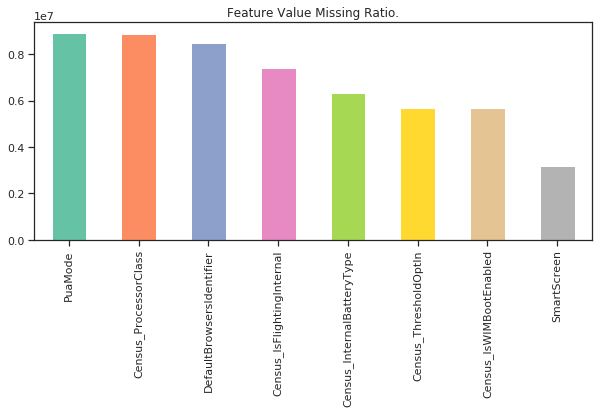

In [15]:
plt.title('Feature Value Missing Ratio.')
_ = high_missing_cols_trn.plot.bar(figsize=(10, 4))

In [16]:
high_missing_cols_all = list(set(high_missing_cols_trn.index.tolist() + high_missing_cols_tst.index.tolist()))
high_missing_cols_all

['Census_ProcessorClass',
 'Census_IsWIMBootEnabled',
 'SmartScreen',
 'Census_IsFlightingInternal',
 'SMode',
 'DefaultBrowsersIdentifier',
 'Census_InternalBatteryType',
 'Census_ThresholdOptIn',
 'PuaMode']

In [17]:
df_trn.drop(high_missing_cols_all, axis=1, inplace=True)
df_tst.drop(high_missing_cols_all, axis=1, inplace=True)

gc.collect()

df_trn.shape, df_tst.shape

((8921483, 73), (7853253, 73))

### Determine types

In [18]:
n_val_unique_trn = df_trn.nunique(dropna=False)
n_val_unique_trn.sort_values()

HasTpm                                                    2
AutoSampleOptIn                                           2
Census_IsSecureBootEnabled                                2
Census_IsTouchEnabled                                     2
IsSxsPassiveMode                                          2
Census_IsPortableOperatingSystem                          2
IsBeta                                                    2
Census_IsPenCapable                                       2
Census_HasOpticalDiskDrive                                2
Census_OSArchitecture                                     3
Processor                                                 3
IsProtected                                               3
Census_IsVirtualDevice                                    3
Census_IsAlwaysOnAlwaysConnectedCapable                   3
Firewall                                                  3
Census_IsFlightsDisabled                                  3
Wdft_IsGamer                            

In [19]:
n_val_unique_tst = df_tst.nunique(dropna=False)
n_val_unique_tst.sort_values()

HasTpm                                                    2
AutoSampleOptIn                                           2
Census_IsSecureBootEnabled                                2
Census_IsTouchEnabled                                     2
IsSxsPassiveMode                                          2
Census_IsPortableOperatingSystem                          2
IsBeta                                                    2
Census_IsPenCapable                                       2
Census_HasOpticalDiskDrive                                2
Census_OSArchitecture                                     3
IsProtected                                               3
Census_IsVirtualDevice                                    3
Census_IsAlwaysOnAlwaysConnectedCapable                   3
Firewall                                                  3
Census_IsFlightsDisabled                                  3
Wdft_IsGamer                                              3
Processor                               

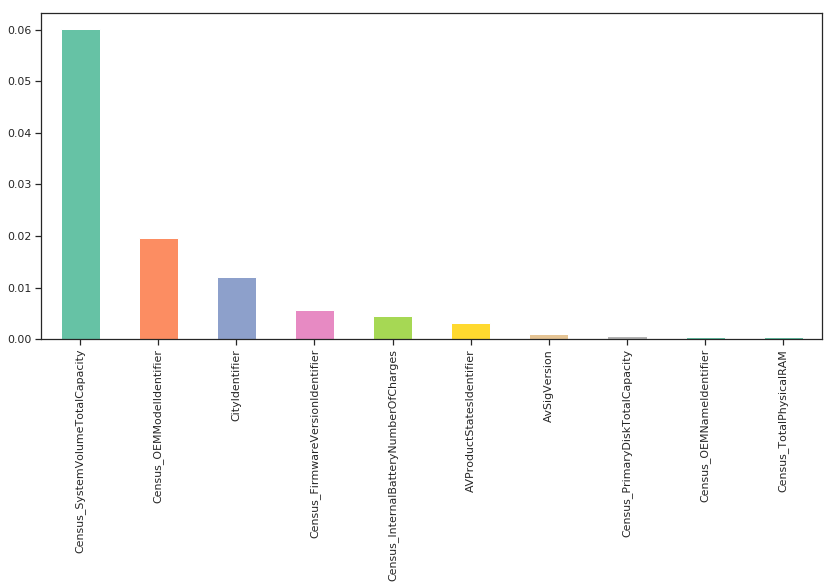

In [23]:
plt.figure(figsize=(14, 6))
_ = (n_val_unique_trn.sort_values(ascending=False)/df_trn.shape[0]).head(10).plot.bar()

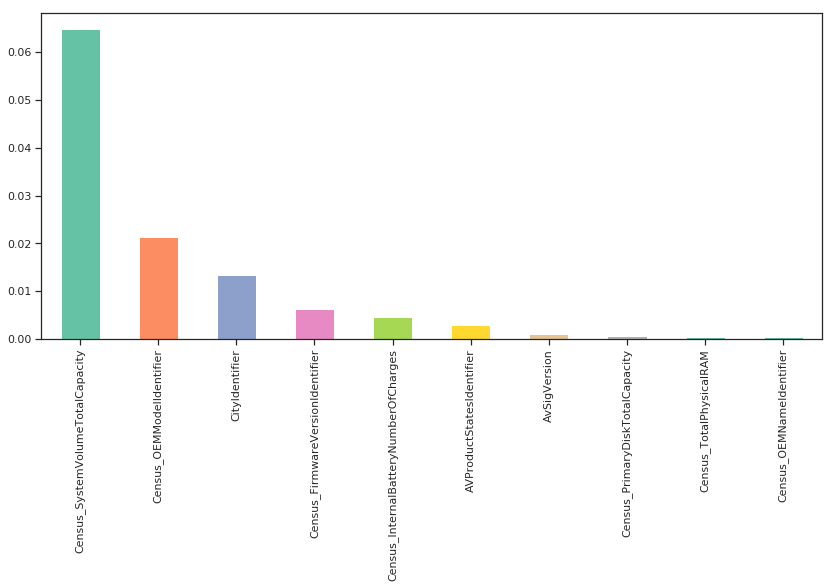

In [24]:
plt.figure(figsize=(14, 6))
_ = (n_val_unique_tst.sort_values(ascending=False)/df_tst.shape[0]).head(10).plot.bar()

In [25]:
cat_cols = list(df_trn.select_dtypes(include=['object']).columns)
num_cols = list(df_trn.select_dtypes(exclude=['object']).columns)

In [26]:
cat_cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [27]:
num_cols

['IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IsProtected',
 'AutoSampleOptIn',
 'IeVerIdentifier',
 'Firewall',
 'UacLuaenable',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'C

In [29]:
bin_cols = n_val_unique_trn[n_val_unique_trn == 2].index.tolist()
bin_cols

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable']

In [31]:
n_val_unique_tst[n_val_unique_tst == 2].index.tolist()

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable']

In [30]:
n_val_unique_trn[n_val_unique_trn == 3]

Processor                                  3
IsProtected                                3
Firewall                                   3
Census_DeviceFamily                        3
Census_OSArchitecture                      3
Census_IsFlightsDisabled                   3
Census_IsVirtualDevice                     3
Census_IsAlwaysOnAlwaysConnectedCapable    3
Wdft_IsGamer                               3
dtype: int64

In [ ]:
# go through
for c in n_values_unique[n_values_unique == 3].index.tolist():
    na_cnt_trn = df_trn[df_trn[c].isna()].shape[0]
    na_cnt_tst = df_tst[df_tst[c].isna()].shape[0]
    if not na_cnt_trn == 0 or not na_cnt_tst == 0:
        bin_cols.append(c)
    print(c + ' NAN', na_cnt_trn, na_cnt_tst)